# Predicción de pasajeros del Titanic con Apache Spark

## REGRESIÓN LOGÍSTICA

Para ello utilizaremos el conjunto de datos [Titanic Passenger]. Ten en cuenta, por supuesto, que en realidad se trata de datos “pequeños” (1309 filas) y que usar Spark en este contexto podría ser exagerado; Este cuaderno es sólo para fines educativos y está destinado a darnos una idea de cómo podemos usar PySpark para construir un modelo de aprendizaje automático.

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Entendiendo el Data Set

El conjunto de datos del Titanic, se deriva de los registros de pasajeros del desafortunado Titanic, que se hundió en 1912. Este conjunto de datos ha sido compilado y puesto a disposición para fines educativos y de investigación, permitiendo analizar los factores que influyeron en la supervivencia durante el desastre.

Los datos contienen una fila por cada pasajero a bordo del Titanic. Cada fila representa un registro individual, con información detallada sobre el pasajero. El objetivo principal es predecir la supervivencia de cada pasajero.

Este conjunto de datos contiene 1309 observaciones sobre los pasajeros del Titanic, con 12 variables que describen características demográficas, socioeconómicas y de viaje.

<p style="text-align: justify;"></p>
<pre>
<strong>PassengerId:</strong> Identificador único para cada pasajero.
<strong>Survived:</strong> Variable objetivo que indica si el pasajero sobrevivió (1) o no (0).
<strong>Pclass:</strong> Clase del boleto del pasajero (1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase).
<strong>Name:</strong> Nombre del pasajero.
<strong>Sex:</strong> Género del pasajero (male o female).
<strong>Age:</strong> Edad del pasajero (en años).
<strong>SibSp:</strong> Número de hermanos/cónyuges a bordo del Titanic.
<strong>Parch:</strong> Número de padres/hijos a bordo del Titanic.
<strong>Ticket:</strong> Número de boleto.
<strong>Fare:</strong> Tarifa que pagó el pasajero por el boleto.
<strong>Cabin:</strong> Número de camarote del pasajero (puede contener valores nulos).
<strong>Embarked:</strong> Puerto de embarque del pasajero (C = Cherbourg, Q = Queenstown, S = Southampton).
</pre>


In [80]:
!pip install pyspark # Instalar la biblioteca PySpark.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null   # Instalar la versión requerida de Java (OpenJDK 8).

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" # Configurar la variable de entorno JAVA_HOME para que PySpark pueda encontrar la instalación de Java.

In [81]:
# Preparamos el entorno para realizar tareas de regresión logistica con PySpark, incluyendo preprocesamiento de datos, entrenamiento de modelos, evaluación y ajuste de hiperparámetros.
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
# Visualizacion
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [84]:
# Establecimiento de semillas aleatorias para la reproductibilidad del cuaderno
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 2.  Creación de la sesión Spark

In [85]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
appname = "Titanic Passenger"

# Se obtiene la sesión por si estuviera abierta previamente y se cierra
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()

# Se crea un contexto nuevo
#conf = SparkConf().setMaster("local[*]").setAppName(appname)
#sc = SparkContext(conf = conf)

spark
#sc

In [86]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#### Github

In [87]:
import pandas as pd

url_train = "https://raw.githubusercontent.com/marcoss6/titanic-dataset/refs/heads/main/train.csv"
url_test = "https://raw.githubusercontent.com/marcoss6/titanic-dataset/refs/heads/main/test.csv"
url_gender = "https://raw.githubusercontent.com/marcoss6/titanic-dataset/refs/heads/main/gender_submission.csv"

train_data = pd.read_csv(url_train)
test_data = pd.read_csv(url_test)
gender_data = pd.read_csv(url_gender)

train_data.head()  # Verifica que se cargaron los datos correctamente
test_data.head()  # Verifica que se cargaron los datos correctamente
gender_data.head()  # Verifica que se cargaron los datos correctamente


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## 3. Cargar los datos de un archivo en un marco de datos

Especificar el esquema al cargar los datos en un DataFrame proporcionará un mejor rendimiento que la inferencia del esquema.

In [88]:
# Definir el esquema, correspondiente a una línea del fichero de datos csv para mejorar el rendimiento.

schema1 = StructType([
    StructField("PassengerId", IntegerType(), True), # Nombre de la columna, Tipo de dato, Indica si la columna puede contener valores nulos
    StructField("Survived", IntegerType(), True),
    StructField("Pclass", IntegerType(), True),
    StructField("Name", StringType(), True),
    StructField("Sex", StringType(), True),
    StructField("Age", FloatType(), True),
    StructField("SibSp", IntegerType(), True),
    StructField("Parch", IntegerType(), True),
    StructField("Ticket", StringType(), True),
    StructField("Fare", FloatType(), True),
    StructField("Cabin", StringType(), True),
    StructField("Embarked", StringType(), True)
])


schema2 = StructType([
    StructField("PassengerId", IntegerType(), True),
    StructField("Pclass", IntegerType(), True),
    StructField("Name", StringType(), True),
    StructField("Sex", StringType(), True),
    StructField("Age", FloatType(), True),
    StructField("SibSp", IntegerType(), True),
    StructField("Parch", IntegerType(), True),
    StructField("Ticket", StringType(), True),
    StructField("Fare", FloatType(), True),
    StructField("Cabin", StringType(), True),
    StructField("Embarked", StringType(), True)
])


 PySpark no puede leer directamente archivos CSV desde URLs como GitHub Raw. PySpark espera archivos locales

In [89]:
# Descargar los archivos CSV a local
!wget -O /content/train.csv "https://raw.githubusercontent.com/marcoss6/titanic-dataset/refs/heads/main/train.csv"
!wget -O /content/test.csv "https://raw.githubusercontent.com/marcoss6/titanic-dataset/refs/heads/main/test.csv"
!wget -O /content/gender_submission.csv "https://raw.githubusercontent.com/marcoss6/titanic-dataset/refs/heads/main/gender_submission.csv"


--2025-03-12 11:59:23--  https://raw.githubusercontent.com/marcoss6/titanic-dataset/refs/heads/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘/content/train.csv’

/content/train.csv  100%[===================>]  59.76K  --.-KB/s    in 0.008s  

2025-03-12 11:59:23 (7.37 MB/s) - ‘/content/train.csv’ saved [61194/61194]

--2025-03-12 11:59:23--  https://raw.githubusercontent.com/marcoss6/titanic-dataset/refs/heads/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28629 

In [90]:
# Cargar los archivos en PySpark desde local
train_df = spark.read.csv("/content/train.csv", schema=schema1, header=True).cache()
test_df = spark.read.csv("/content/test.csv", schema=schema2, header=True).cache()
gender_df = spark.read.csv("/content/gender_submission.csv", header=True).cache()


In [91]:
# Vistazo de los datos

print("📌 TRAIN DATA")
train_df.printSchema()  # Muestra la estructura del DataFrame
train_df.show(5)  # Muestra las primeras 5 filas

print("📌 TEST DATA")
test_df.printSchema()
test_df.show(5)

print("📌 GENDER SUBMISSION")
gender_df.printSchema()
gender_df.show(5)


📌 TRAIN DATA
root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    

In [92]:
# Mostrar las columnas del marco de datos
train_df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

## 4. Exploración de datos

In [93]:
# DATOS DE TRAIN

# Varibales numéricas
train_df.select("Age", "SibSp", "Parch", "Fare").describe().show()

# Varibales cualitativas
train_df.groupBy("Survived").count().show()
train_df.groupBy("Pclass").count().show()
train_df.groupBy("Sex").count().show()
train_df.groupBy("Embarked").count().show()

+-------+------------------+------------------+-------------------+-----------------+
|summary|               Age|             SibSp|              Parch|             Fare|
+-------+------------------+------------------+-------------------+-----------------+
|  count|               714|               891|                891|              891|
|   mean| 29.69911764704046|0.5230078563411896|0.38159371492704824|32.20420804114722|
| stddev|14.526497332370992|1.1027434322934315| 0.8060572211299488|49.69342916316158|
|    min|              0.42|                 0|                  0|              0.0|
|    max|              80.0|                 8|                  6|         512.3292|
+-------+------------------+------------------+-------------------+-----------------+

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+

+------+-----+
|Pclass|count|
+------+-----+
|     1|  216|
|     3|  491|
|     2|  184|
+------+-----+

+------+-----+
|

In [94]:
# Mostrar las columnas del marco de datos
test_df.columns

['PassengerId',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [95]:
# DATOS DE TEST

# Varibales numéricas
train_df.select("Age", "SibSp", "Parch", "Fare").describe().show()

# Varibales cualitativas
train_df.groupBy("Pclass").count().show()
train_df.groupBy("Sex").count().show()
train_df.groupBy("Embarked").count().show()

+-------+------------------+------------------+-------------------+-----------------+
|summary|               Age|             SibSp|              Parch|             Fare|
+-------+------------------+------------------+-------------------+-----------------+
|  count|               714|               891|                891|              891|
|   mean| 29.69911764704046|0.5230078563411896|0.38159371492704824|32.20420804114722|
| stddev|14.526497332370992|1.1027434322934315| 0.8060572211299488|49.69342916316158|
|    min|              0.42|                 0|                  0|              0.0|
|    max|              80.0|                 8|                  6|         512.3292|
+-------+------------------+------------------+-------------------+-----------------+

+------+-----+
|Pclass|count|
+------+-----+
|     1|  216|
|     3|  491|
|     2|  184|
+------+-----+

+------+-----+
|   Sex|count|
+------+-----+
|female|  314|
|  male|  577|
+------+-----+

+--------+-----+
|Embarked|c

In [96]:
# Ejecutar una selección de muestras

train_df.select('Pclass', 'Sex', 'Age', 'Survived').show(10)

+------+------+----+--------+
|Pclass|   Sex| Age|Survived|
+------+------+----+--------+
|     3|  male|22.0|       0|
|     1|female|38.0|       1|
|     3|female|26.0|       1|
|     1|female|35.0|       1|
|     3|  male|35.0|       0|
|     3|  male|NULL|       0|
|     1|  male|54.0|       0|
|     3|  male| 2.0|       0|
|     3|female|27.0|       1|
|     2|female|14.0|       1|
+------+------+----+--------+
only showing top 10 rows



### 4.1 Distribución de edades de las personas que estuvieron en el Titanic:


In [97]:
# Podemos agrupar a los pasajeros por edad y contar cuántos hay en cada grupo:
from pyspark.sql.functions import count
result_df = train_df.groupBy("Age").agg(count("*").alias("count")).sort("Age", ascending=True)
result_df.show(10)


+----+-----+
| Age|count|
+----+-----+
|NULL|  177|
|0.42|    1|
|0.67|    1|
|0.75|    2|
|0.83|    2|
|0.92|    1|
| 1.0|    7|
| 2.0|   10|
| 3.0|    6|
| 4.0|   10|
+----+-----+
only showing top 10 rows



<Figure size 1400x600 with 0 Axes>

<BarContainer object of 89 artists>

Text(0.5, 0, 'Edad')

Text(0, 0.5, 'Número de pasajeros')

Text(0.5, 1.0, 'Distribución de edades de los pasajeros')

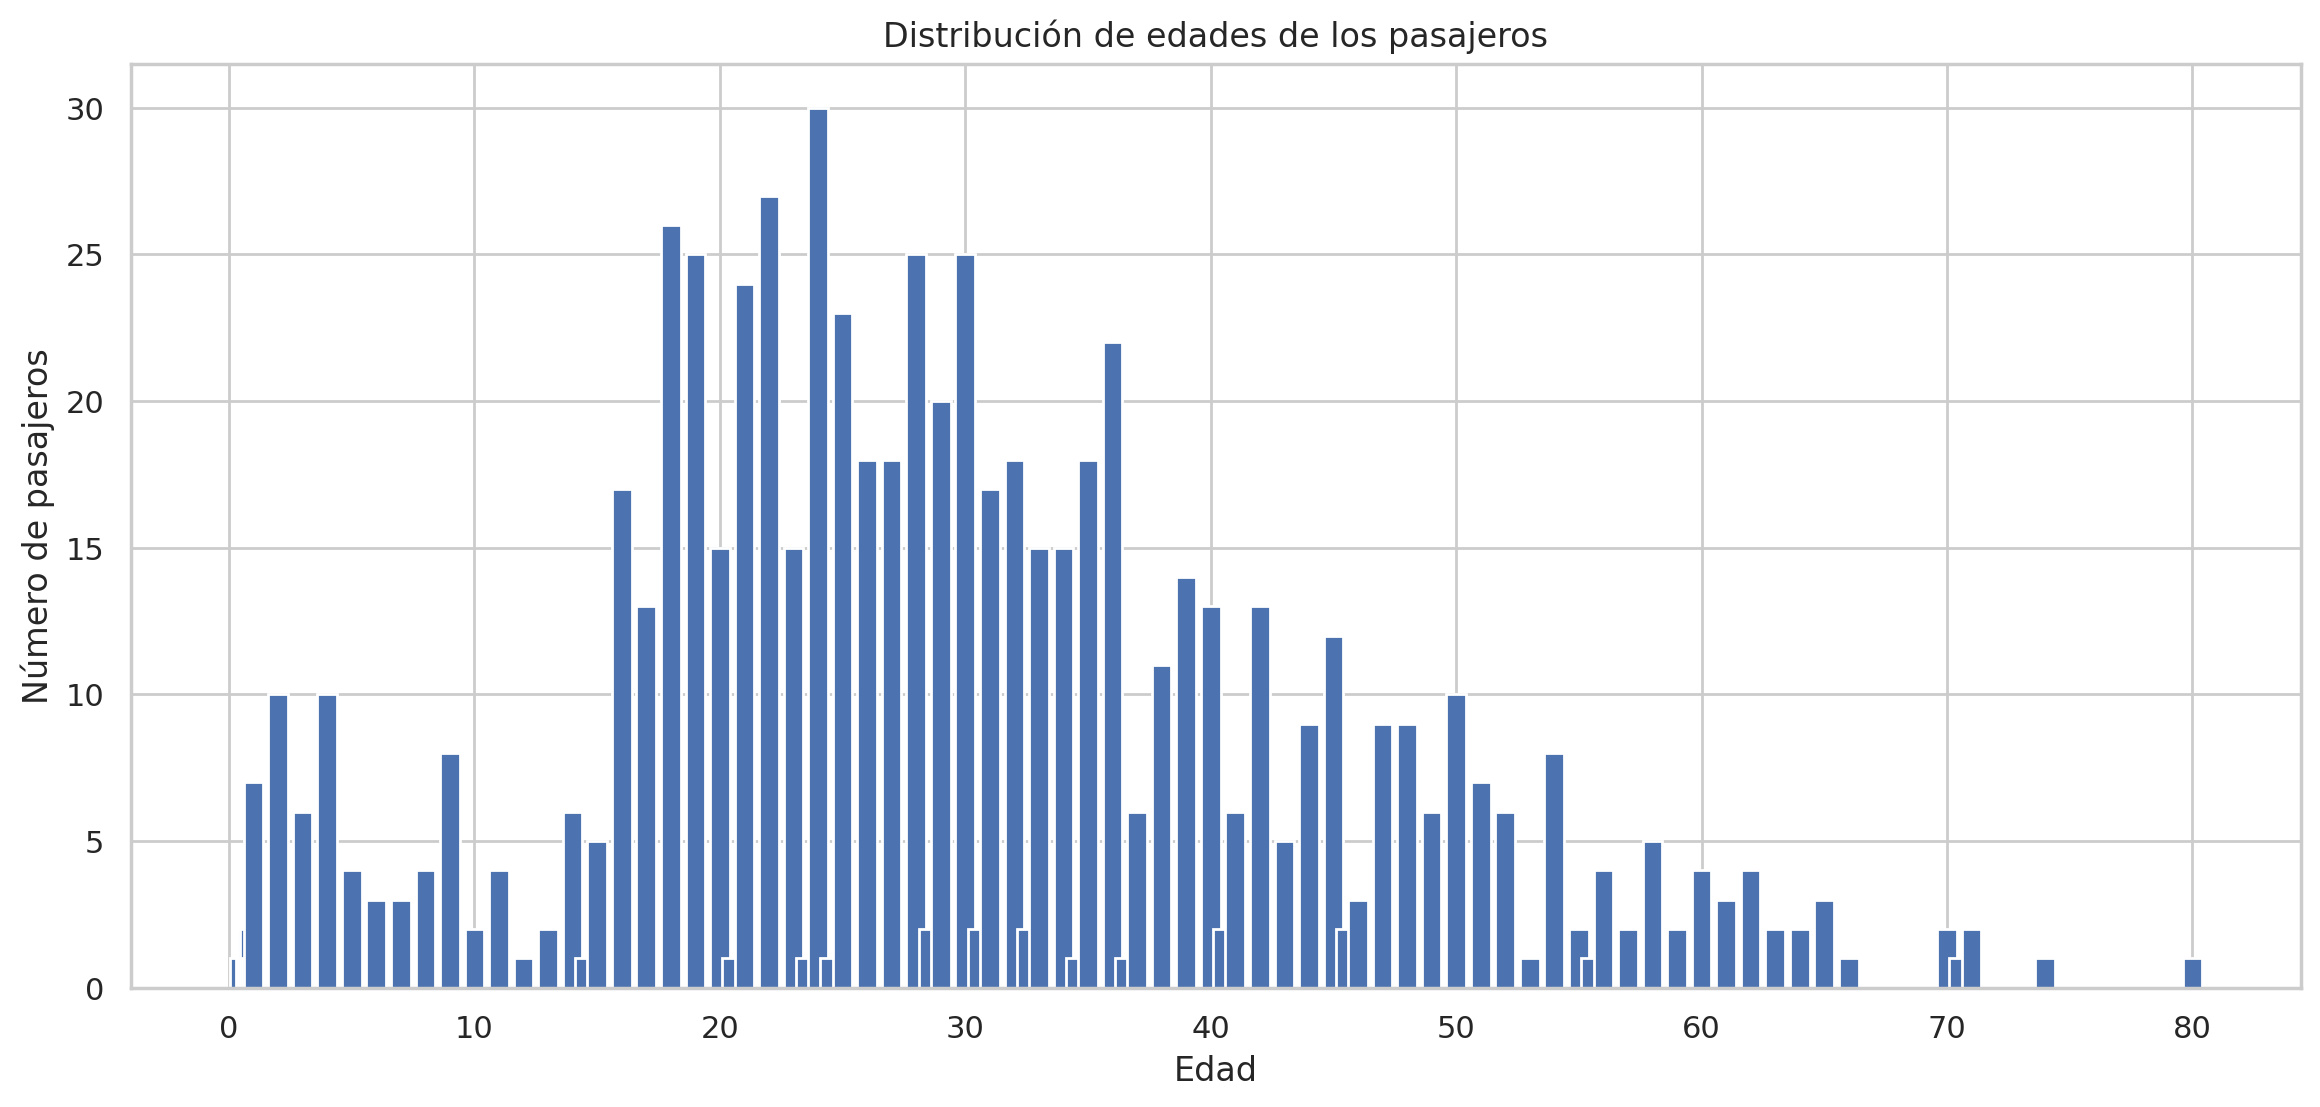

In [98]:
# Graficar la distribución de edades:

import matplotlib.pyplot as plt
import pandas as pd

# Convertir el DataFrame de Spark a Pandas para graficar
result_pd = result_df.toPandas()

# Crear gráfico de barras
plt.figure(figsize=(14, 6))
plt.bar(result_pd["Age"], result_pd["count"])
plt.xlabel("Edad")
plt.ylabel("Número de pasajeros")
plt.title("Distribución de edades de los pasajeros")
plt.show()

La distribución de edades muestra que la mayoría de los pasajeros del Titanic eran jóvenes adultos, con un pico de frecuencia entre los **20 y 30 años**. También se observa un número considerable de pasajeros menores de 10 años. A medida que aumenta la edad, el número de pasajeros disminuye progresivamente.

### 4.2 Estadísticas de resumen:

Los DataFrames de Spark incluyen algunas funciones incorporadas para el procesamiento estadístico. La función describe() realiza cálculos estadísticos de resumen en todas las columnas numéricas y los devuelve como un DataFrame.

In [99]:
from pyspark.sql.functions import round

train_df.describe().select(
    "summary",
    round("Age", 2).alias("Age"),
    round("Fare", 2).alias("Fare"),
    round("SibSp", 2).alias("SibSp"),
    round("Parch", 2).alias("Parch")
).show()


+-------+-----+------+-----+-----+
|summary|  Age|  Fare|SibSp|Parch|
+-------+-----+------+-----+-----+
|  count|714.0| 891.0|891.0|891.0|
|   mean| 29.7|  32.2| 0.52| 0.38|
| stddev|14.53| 49.69|  1.1| 0.81|
|    min| 0.42|   0.0|  0.0|  0.0|
|    max| 80.0|512.33|  8.0|  6.0|
+-------+-----+------+-----+-----+



Observe los valores mínimo y máximo de todos los atributos (numéricos). Vemos que múltiples atributos tienen un amplio rango de valores: necesitaremos normalizar tu conjunto de datos.

## 5. Preprocesamiento de los datos

Con toda esta información que hemos recopilado de nuestro pequeño análisis exploratorio de datos, sabemos lo suficiente para preprocesar nuestros datos para introducirlos en el modelo.

+ Manejo de valores nulos: Algunas columnas, como "Age" y "Cabin", tienen valores faltantes que debemos gestionar.
+ Estandarización de los datos: Algunas variables como "Fare" tienen un rango amplio de valores, por lo que podemos normalizarlas.
+ Creación de nuevas variables: Podemos agregar atributos útiles, como el tamaño de la familia.
+ Conversión de variables categóricas: Debemos convertir variables como "Sex" y "Embarked" en valores numéricos ya que los modelos matemáticos solo entienden números, mejora el rendimiento del modelo y facilita el cálculo de distancias.

### 5.1 Manejo de valores nulos



In [100]:
# Primero, verificamos cuántos valores faltantes hay en cada columna:
from pyspark.sql.functions import col, isnan, when, count

train_df.select([count(when(col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()
test_df.select([count(when(col(c).isNull(), c)).alias(c) for c in test_df.columns]).show()
gender_df.select([count(when(col(c).isNull(), c)).alias(c) for c in gender_df.columns]).show()


+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+

+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0| 86|    0|    0|     0|   1|  327|       0|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+

+-----------+--------+
|PassengerId|Survived|
+-----------+--------+
|          0|       0|
+-----------+--------+



In [101]:
from pyspark.sql.functions import col, lit

# Rellenar los valores nulos de "Age" con la mediana de las edades, ya que la distribución de edad no es uniforme.
mediana_edad = train_df.approxQuantile("Age", [0.5], 0.01)[0]
train_df = train_df.fillna({"Age": mediana_edad})

# Rellenar "Cabin" con "Unknown" para indicar que no se conoce el camarote. Tiene demasiados valores nulos (687 de 891)
train_df = train_df.fillna({"Cabin": "Unknown"})

# Rellenar "Embarked" con la moda (el valor más frecuente) ya que solo tiene 2 valores nulos en train_df
moda_embarked = train_df.groupBy("Embarked").count().orderBy(col("count").desc()).first()[0]
train_df = train_df.fillna({"Embarked": moda_embarked})

#TEST

# Rellenar los valores nulos de "Age" con la mediana
mediana_edad_test = test_df.approxQuantile("Age", [0.5], 0.01)[0]
test_df = test_df.fillna({"Age": mediana_edad_test})

# Rellenar "Cabin" con "Unknown" ya que tiene muchos valores nulos (327 de 418)
test_df = test_df.fillna({"Cabin": "Unknown"})

# Rellenar "Fare" con la moda de las tarifas, ya que solo tiene 1 valor nulo
moda_fare = test_df.groupBy("Fare").count().orderBy(col("count").desc()).first()[0]
test_df = test_df.fillna({"Fare": moda_fare})

# Verificar que ya no hay valores nulos
train_df.select([count(when(col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()
test_df.select([count(when(col(c).isNull(), c)).alias(c) for c in test_df.columns]).show()


+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+

+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+



####  Conversión de variables categóricas

Las variables "Sex" y "Embarked" deben convertirse en valores numéricos para ser usadas en un modelo de Machine Learning.

In [102]:
train_df.groupBy("Embarked").count().show() # Contar cuántas veces aparece cada valor
test_df.groupBy("Embarked").count().show() # Contar cuántas veces aparece cada valor
train_df.groupBy("Sex").count().show() # Contar cuántas veces aparece cada valor
test_df.groupBy("Sex").count().show() # Contar cuántas veces aparece cada valor

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|       C|  168|
|       S|  646|
+--------+-----+

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   46|
|       C|  102|
|       S|  270|
+--------+-----+

+------+-----+
|   Sex|count|
+------+-----+
|female|  314|
|  male|  577|
+------+-----+

+------+-----+
|   Sex|count|
+------+-----+
|female|  152|
|  male|  266|
+------+-----+



StringIndexer asigna 0.0 a la categoría más frecuente, 1.0 a la segunda más común, y así sucesivamente.


In [103]:
from pyspark.ml.feature import StringIndexer

# Convertir "Sex" a valores numéricos (0 = male, 1 = female) en train y test
indexer_sex = StringIndexer(inputCol="Sex", outputCol="SexIndex")
train_df = indexer_sex.fit(train_df).transform(train_df)
test_df = indexer_sex.fit(test_df).transform(test_df)

# Convertir "Embarked" a valores numéricos (generalmente: 0 = S, 1 = C, 2 = Q) en train y test
indexer_embarked = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex")
train_df = indexer_embarked.fit(train_df).transform(train_df)
test_df = indexer_embarked.fit(test_df).transform(test_df)

# Verificar los valores de "Sex" en ambos datasets
print("Valores únicos de Sex en train_df:")
train_df.select("Sex", "SexIndex").distinct().show()

print("Valores únicos de Sex en test_df:")
test_df.select("Sex", "SexIndex").distinct().show()

# Verificar los valores de "Embarked" en ambos datasets
print("Valores únicos de Embarked en train_df:")
train_df.select("Embarked", "EmbarkedIndex").distinct().show()

print("Valores únicos de Embarked en test_df:")
test_df.select("Embarked", "EmbarkedIndex").distinct().show()



Valores únicos de Sex en train_df:
+------+--------+
|   Sex|SexIndex|
+------+--------+
|  male|     0.0|
|female|     1.0|
+------+--------+

Valores únicos de Sex en test_df:
+------+--------+
|   Sex|SexIndex|
+------+--------+
|  male|     0.0|
|female|     1.0|
+------+--------+

Valores únicos de Embarked en train_df:
+--------+-------------+
|Embarked|EmbarkedIndex|
+--------+-------------+
|       Q|          2.0|
|       S|          0.0|
|       C|          1.0|
+--------+-------------+

Valores únicos de Embarked en test_df:
+--------+-------------+
|Embarked|EmbarkedIndex|
+--------+-------------+
|       Q|          2.0|
|       S|          0.0|
|       C|          1.0|
+--------+-------------+



In [104]:
# Verificacion
train_df.show(5)
test_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-------+--------+--------+-------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|  Cabin|Embarked|SexIndex|EmbarkedIndex|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-------+--------+--------+-------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|Unknown|       S|     0.0|          0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|    C85|       C|     1.0|          1.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|Unknown|       S|     1.0|          0.0|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|   C123|       S|     1.0|          0.0|
|          5|       

## 6. Ingeniería de características
Ahora que hemos tratado los valores nulos en nuestro conjunto de datos, procederemos a crear nuevas características que pueden mejorar el rendimiento del modelo. Estas nuevas variables nos permitirán capturar mejor las relaciones entre los pasajeros y sus probabilidades de supervivencia.



+ Tamaño de la familia: Representa el número total de familiares que viajan con el pasajero, sumando hermanos/esposos (SibSp) y padres/hijos (Parch), más el pasajero mismo. Esto nos ayudará a entender si viajar en grupo pudo influir en la supervivencia.
+ Pasajero viajando solo: Indicador que nos dirá si el pasajero viajaba solo (1) o acompañado (0). Se ha demostrado que los pasajeros que viajaban solos podrían haber tenido menos apoyo al momento de la evacuación.

Estas nuevas variables pueden aportar información valiosa sobre el comportamiento de los pasajeros y su impacto en la probabilidad de supervivencia.

In [105]:
train_df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'SexIndex',
 'EmbarkedIndex']

In [106]:
# Añadiendo las nuevas columnas al `df`

from pyspark.sql.functions import col, when, regexp_extract

# Crear la variable "FamilySize"
train_df = train_df.withColumn("FamilySize", col("SibSp") + col("Parch") + 1) # suma de SibSp + Parch + el pasajero mismo.
test_df = test_df.withColumn("FamilySize", col("SibSp") + col("Parch") + 1)

# Crear la variable "IsAlone"
train_df = train_df.withColumn("IsAlone", when(col("FamilySize") == 1, 1).otherwise(0)) # Indicador binario (1 si el pasajero viaja solo, 0 si viaja con familiares).
test_df = test_df.withColumn("IsAlone", when(col("FamilySize") == 1, 1).otherwise(0))


In [107]:
# Ver los cambios en las primeras filas
train_df.select("SibSp", "Parch", "FamilySize", "IsAlone").show(5)
test_df.select("SibSp", "Parch", "FamilySize", "IsAlone").show(5)

+-----+-----+----------+-------+
|SibSp|Parch|FamilySize|IsAlone|
+-----+-----+----------+-------+
|    1|    0|         2|      0|
|    1|    0|         2|      0|
|    0|    0|         1|      1|
|    1|    0|         2|      0|
|    0|    0|         1|      1|
+-----+-----+----------+-------+
only showing top 5 rows

+-----+-----+----------+-------+
|SibSp|Parch|FamilySize|IsAlone|
+-----+-----+----------+-------+
|    0|    0|         1|      1|
|    1|    0|         2|      0|
|    0|    0|         1|      1|
|    0|    0|         1|      1|
|    1|    1|         3|      0|
+-----+-----+----------+-------+
only showing top 5 rows



Podemos observar que las nuevas variables FamilySize e IsAlone han sido correctamente generadas. En la primera fila, el pasajero tiene un FamilySize de 2, lo que indica que viajaba acompañado de un familiar. En contraste, otros pasajeros tienen un FamilySize de 1, lo que significa que viajaban solos y, por lo tanto, IsAlone toma el valor de 1.

Dado que estas nuevas características reflejan la composición familiar de cada pasajero, pueden ser relevantes para el análisis. Se espera que los pasajeros que viajaban acompañados tuvieran más apoyo al momento de la evacuación, mientras que aquellos que viajaban solos podrían haber estado en desventaja.

En los siguientes pasos, realizaremos la selección de características y la normalización de aquellas variables que sean necesarias para el modelo. También es importante decidir qué columnas dejaremos fuera del análisis si no aportan valor predictivo.

In [108]:
# Reordenar y seleccionar las columnas importantes
train_df = train_df.select("Survived",  # Variable objetivo
                           "Pclass",
                           "SexIndex",
                           "Age",
                           "SibSp",
                           "Parch",
                           "Fare",
                           "EmbarkedIndex",
                           "FamilySize",
                           "IsAlone")

test_df = test_df.select("PassengerId",  # Importante para la predicción final
                          "Pclass",
                          "SexIndex",
                          "Age",
                          "SibSp",
                          "Parch",
                          "Fare",
                          "EmbarkedIndex",
                          "FamilySize",
                          "IsAlone")

# Verificar que la selección y el orden sean correctos
train_df.show(5)
test_df.show(5)


+--------+------+--------+----+-----+-----+-------+-------------+----------+-------+
|Survived|Pclass|SexIndex| Age|SibSp|Parch|   Fare|EmbarkedIndex|FamilySize|IsAlone|
+--------+------+--------+----+-----+-----+-------+-------------+----------+-------+
|       0|     3|     0.0|22.0|    1|    0|   7.25|          0.0|         2|      0|
|       1|     1|     1.0|38.0|    1|    0|71.2833|          1.0|         2|      0|
|       1|     3|     1.0|26.0|    0|    0|  7.925|          0.0|         1|      1|
|       1|     1|     1.0|35.0|    1|    0|   53.1|          0.0|         2|      0|
|       0|     3|     0.0|35.0|    0|    0|   8.05|          0.0|         1|      1|
+--------+------+--------+----+-----+-----+-------+-------------+----------+-------+
only showing top 5 rows

+-----------+------+--------+----+-----+-----+-------+-------------+----------+-------+
|PassengerId|Pclass|SexIndex| Age|SibSp|Parch|   Fare|EmbarkedIndex|FamilySize|IsAlone|
+-----------+------+--------+----+

Las variables predictoras clave incluyen "Pclass", "Sex", "Age", "Fare" y "Embarked", que son esenciales para el modelo.

Las nuevas variables (FamilySize e IsAlone) se mantienen en el dataset porque pueden mejorar la predicción.

Se deja "PassengerId" en test_df para que podamos generar la salida correctamente cuando hagamos predicciones.

Se eliminan columnas como "Name", "Ticket" y "Cabin", ya que no se van a utilizar en el modelo.

### 6.1 Extracción de características

Ahora que hemos reordenado los datos, estamos listos para normalizarlos. Vamos a elegir las características a normalizar.

In [109]:
# Seleccionar las columnas a usar en el vector de características
featureCols = ["Pclass", "SexIndex", "Age", "Fare", "EmbarkedIndex", "FamilySize", "IsAlone"]

In [110]:
# poner características en una columna de vectores de características
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

In [111]:
# Se añade una nueva columna "features" que contiene todas las variables de featureCols en un vector denso.
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

In [112]:
# Verificar el resultado
train_df.select("features").show(10, truncate=False)

+---------------------------------------------+
|features                                     |
+---------------------------------------------+
|[3.0,0.0,22.0,7.25,0.0,2.0,0.0]              |
|[1.0,1.0,38.0,71.2833023071289,1.0,2.0,0.0]  |
|[3.0,1.0,26.0,7.925000190734863,0.0,1.0,1.0] |
|[1.0,1.0,35.0,53.099998474121094,0.0,2.0,0.0]|
|[3.0,0.0,35.0,8.050000190734863,0.0,1.0,1.0] |
|[3.0,0.0,28.0,8.45829963684082,2.0,1.0,1.0]  |
|[1.0,0.0,54.0,51.86249923706055,0.0,1.0,1.0] |
|[3.0,0.0,2.0,21.075000762939453,0.0,5.0,0.0] |
|[3.0,1.0,27.0,11.133299827575684,0.0,3.0,0.0]|
|[2.0,1.0,14.0,30.07080078125,1.0,2.0,0.0]    |
+---------------------------------------------+
only showing top 10 rows



Todas las características se han transformado en un Vector Denso.

### 6.2 Estandarización

A continuación, podemos finalmente escalar los datos utilizando `StandardScaler`. Las columnas de entrada son las `características`, y la columna de salida con el reescalado que se incluirá en el scaled_df se llamará `«features_scaled»`:

In [113]:
# Inicializar el StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [114]:
# Ajustar y transformar los datos de entrenamiento
scaler_model = scaler.fit(train_df)
train_df = scaler_model.transform(train_df)

In [115]:
# Aplicar la transformación en los datos de prueba
test_df = scaler_model.transform(test_df)

In [116]:
# Inspeccionar el resultado
train_df.select("features", "features_scaled").show(10, truncate=False)

+---------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+
|features                                     |features_scaled                                                                                                        |
+---------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+
|[3.0,0.0,22.0,7.25,0.0,2.0,0.0]              |[3.5882109717039685,0.0,1.6897475232093926,0.1458945402257434,0.0,1.2395732203445837,0.0]                              |
|[1.0,1.0,38.0,71.2833023071289,1.0,2.0,0.0]  |[1.1960703239013228,2.0920936665593883,2.9186548128162233,1.4344613263270685,1.5731347156790287,1.2395732203445837,0.0]|
|[3.0,1.0,26.0,7.925000190734863,0.0,1.0,1.0] |[3.5882109717039685,2.0920936665593883,1.9969743456111002,0.15947782884361264,0.0,0.6197866101722919,2.0424201265

In [117]:
import pandas as pd

# Convertir features escaladas en una lista de valores
train_scaled = train_df.select("features_scaled").collect()
test_scaled = test_df.select("features_scaled").collect()

# Ver los primeros valores
print(train_scaled[:5])  # Muestra los primeros 5 valores escalados
print(test_scaled[:5])   # Muestra los primeros 5 valores escalados



[Row(features_scaled=DenseVector([3.5882, 0.0, 1.6897, 0.1459, 0.0, 1.2396, 0.0])), Row(features_scaled=DenseVector([1.1961, 2.0921, 2.9187, 1.4345, 1.5731, 1.2396, 0.0])), Row(features_scaled=DenseVector([3.5882, 2.0921, 1.997, 0.1595, 0.0, 0.6198, 2.0424])), Row(features_scaled=DenseVector([1.1961, 2.0921, 2.6882, 1.0686, 0.0, 1.2396, 0.0])), Row(features_scaled=DenseVector([3.5882, 0.0, 2.6882, 0.162, 0.0, 0.6198, 2.0424]))]
[Row(features_scaled=DenseVector([3.5882, 0.0, 2.6498, 0.1576, 3.1463, 0.6198, 2.0424])), Row(features_scaled=DenseVector([3.5882, 2.0921, 3.6099, 0.1409, 0.0, 1.2396, 0.0])), Row(features_scaled=DenseVector([2.3921, 0.0, 4.762, 0.1949, 3.1463, 0.6198, 2.0424])), Row(features_scaled=DenseVector([3.5882, 0.0, 2.0738, 0.1743, 0.0, 0.6198, 2.0424])), Row(features_scaled=DenseVector([3.5882, 2.0921, 1.6897, 0.2473, 0.0, 1.8594, 0.0]))]


In [118]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.sql.types import ArrayType, DoubleType

# Crear una SparkSession
spark = SparkSession.builder \
    .appName("Vector Conversion") \
    .getOrCreate()

# Ejemplo de DataFrame con una columna de vector denso
data = train_df.select("features_scaled").rdd.map(lambda row: (DenseVector(row["features_scaled"]),)).collect()
df = spark.createDataFrame(data, ["dense_vector"]) # Convertir en DataFrame con la estructura esperada

# Definir una función UDF para convertir un vector denso en una lista normal
def to_normal_vector(dense_vector):
    return dense_vector.toArray().tolist() # Convierte correctamente el vector en lista

# Registrar la UDF en Spark
to_normal_vector_udf = udf(to_normal_vector, ArrayType(DoubleType()))

# Aplicar la UDF al DataFrame
df = df.withColumn("normal_vector", to_normal_vector_udf("dense_vector")) # Aplica la conversión y crea la nueva columna "normal_vector".

# Show the DataFrame
l2 = df.select('normal_vector')
l2.show(5, truncate=False)  # Mostrar primeras 5 filas

+-----------------------------------------------------------------------------------------------------------------------------+
|normal_vector                                                                                                                |
+-----------------------------------------------------------------------------------------------------------------------------+
|[3.5882109717039685, 0.0, 1.6897475232093926, 0.1458945402257434, 0.0, 1.2395732203445837, 0.0]                              |
|[1.1960703239013228, 2.0920936665593883, 2.9186548128162233, 1.4344613263270685, 1.5731347156790287, 1.2395732203445837, 0.0]|
|[3.5882109717039685, 2.0920936665593883, 1.9969743456111002, 0.15947782884361264, 0.0, 0.6197866101722919, 2.042420126586927]|
|[1.1960703239013228, 2.0920936665593883, 2.6882346960149426, 1.068551705292355, 0.0, 1.2395732203445837, 0.0]                |
|[3.5882109717039685, 0.0, 2.6882346960149426, 0.16199325195095304, 0.0, 0.6197866101722919, 2.042420126

### 7. Construir un modelo de aprendizaje automático con Spark ML

Con todo el preprocesamiento hecho, ¡por fin es hora de empezar a construir nuestro modelo de Regresión Logística! Como siempre, primero tenemos que dividir los datos en conjuntos de entrenamiento y de prueba. Por suerte, esto no es un problema con el método `randomSplit()`:

### 7.1 Particionar el conjunto de datos

NO usamos randomSplit() porque ya tenemos train_df y test_df

### 7.2. Creación y evaluación de un modelo de Regresión Logística

Cree un modelo de regresión logística a partir de la partición del conjunto de datos de entrenamiento. Y con nuestro modelo en su lugar, podemos generar predicciones para nuestros datos de prueba: utilizar el método `transform()` para predecir las etiquetas de nuestros `datos_de_prueba`. A continuación, podemos utilizar las operaciones RDD para extraer las predicciones, así como las etiquetas verdaderas del DataFrame.

In [119]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features_scaled",  # Columna con las características del modelo
    labelCol="Survived",            # Columna objetivo (lo que queremos predecir)
    predictionCol="prediction",      # Nombre de la columna donde se guardarán las predicciones
    maxIter=100,                     # Número máximo de iteraciones para la optimización
    regParam=0.01,                    # Parámetro de regularización (lambda)
    elasticNetParam=0.5,               # Parámetro Elastic Net (combinación de L1 y L2)
    standardization=False              # No estandarizar las características internamente
)


# Reentrenar el modelo con los nuevos parámetros
logisticModel = lr.fit(train_df)

#### 7.2.2 Inspeccionar coeficientes del modelo

In [120]:
print("Coeficientes del modelo:")
print(logisticModel.coefficients)

Coeficientes del modelo:
[-0.7870412339747069,1.166502382862064,-0.38409304656538257,0.08530640824303984,0.11791722302117458,-0.4124491580902925,-0.22517264936417603]


In [121]:
print("\nIntercepto del modelo:")
print(logisticModel.intercept)


Intercepto del modelo:
2.197771447831115


In [122]:
# Crear un DataFrame con los coeficientes del modelo
coeff_df = pd.DataFrame({
    "Feature": ["Intercept"] + featureCols,  # Lista de características incluyendo el intercepto
    "Co-efficients": np.insert(logisticModel.coefficients.toArray(), 0, logisticModel.intercept)  # Insertar intercepto en la primera posición
})

coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [123]:
coeff_df

,Feature,Co-efficients
0,Intercept,2.197771
1,Pclass,-0.787041
2,SexIndex,1.166502
3,Age,-0.384093
4,Fare,0.085306
5,EmbarkedIndex,0.117917
6,FamilySize,-0.412449
7,IsAlone,-0.225173


#### 7.2.3 Generación de predicciones

In [124]:
# Generar predicciones en test_df
predictions = logisticModel.transform(test_df)

#Genera nuevas columnas en test_df, incluyendo:

# rawPrediction → Valores antes de aplicar la función sigmoide.
# probability → Probabilidad de que el pasajero haya sobrevivido.
# prediction → 0 (no sobrevivió) o 1 (sobrevivió), según el umbral de 0.5.

#### Agregar columna "Survided" a los datos de test
Unir las predicciones con los valores reales de gender_df para evaluación:

In [125]:
# Agregamos Survived de gender_df a predictions (mismas columnas de test_df, pero se añaden nuevas columnas generadas por el modelo)
predictions = predictions.join(gender_df.select("PassengerId", "Survived"), on="PassengerId", how="left")

# Verificar que ahora predictions tiene la columna Survived
predictions.select("PassengerId", "Survived").show(5)

+-----------+--------+
|PassengerId|Survived|
+-----------+--------+
|        892|       0|
|        893|       1|
|        894|       0|
|        895|       0|
|        896|       1|
+-----------+--------+
only showing top 5 rows



In [126]:
predictions.dtypes

[('PassengerId', 'int'),
 ('Pclass', 'int'),
 ('SexIndex', 'double'),
 ('Age', 'float'),
 ('SibSp', 'int'),
 ('Parch', 'int'),
 ('Fare', 'float'),
 ('EmbarkedIndex', 'double'),
 ('FamilySize', 'int'),
 ('IsAlone', 'int'),
 ('features', 'vector'),
 ('features_scaled', 'vector'),
 ('rawPrediction', 'vector'),
 ('probability', 'vector'),
 ('prediction', 'double'),
 ('Survived', 'string')]

In [127]:
predictions = predictions.withColumn("Survived", col("Survived").cast(IntegerType()))
predictions.printSchema() # Verificar

root
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- SexIndex: double (nullable = false)
 |-- Age: float (nullable = false)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: float (nullable = false)
 |-- EmbarkedIndex: double (nullable = false)
 |-- FamilySize: integer (nullable = true)
 |-- IsAlone: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)
 |-- Survived: integer (nullable = true)



In [128]:
# Seleccionar solo las columnas relevantes
pred_and_labels = predictions.select("prediction", "Survived")

In [129]:
# Mostrar algunas predicciones
print("Predicciones vs Valores reales:")
pred_and_labels.show(10)

Predicciones vs Valores reales:
+----------+--------+
|prediction|Survived|
+----------+--------+
|       0.0|       0|
|       0.0|       1|
|       0.0|       0|
|       0.0|       0|
|       1.0|       1|
|       0.0|       0|
|       1.0|       1|
|       0.0|       0|
|       1.0|       1|
|       0.0|       0|
+----------+--------+
only showing top 10 rows



#### 7.2.4 Inspeccionar las métricas

Mirar los valores predichos es una cosa, pero otra y mejor es mirar algunas métricas para tener una mejor idea de lo bueno que es realmente tu modelo.

¿Qué métricas podemos usar en Regresión Logística?
En lugar de RMSE, R² y MAE, las métricas correctas para clasificación son:

🔹 Accuracy → Proporción de predicciones correctas.

🔹 F1-score → Equilibrio entre precisión y recall.

🔹 AUC (Area Under ROC Curve) → Mide la capacidad del modelo para separar clases.

In [130]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Obtener la precisión
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
accuracy_rf = accuracy_evaluator.evaluate(predictions)
print(f"🔹 Precisión (Accuracy) del modelo: {accuracy_rf:.4f}")

🔹 Precisión (Accuracy) del modelo: 0.9522


In [131]:
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="f1")
f1_rf = f1_evaluator.evaluate(predictions)
print(f"🔹 F1-score del modelo: {f1_rf:.4f}")

🔹 F1-score del modelo: 0.9522


**Evaluar con BinaryClassificationEvaluator:**

In [132]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluador para AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="Survived", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions)

print("🔹 AUC en test: {0}".format(auc))


🔹 AUC en test: 0.949718045112782


Esto nos dice qué tan bien el modelo separa 0 y 1 en test_df.



### 7.3 Creación y evaluación de un modelo de bosque aleatorio

#### 7.3.1 Entrenamiento del modelo RF

In [133]:
from pyspark.ml.classification import RandomForestClassifier

# Definir el modelo Random Forest
rf = RandomForestClassifier(featuresCol="features_scaled", labelCol="Survived", predictionCol="prediction", numTrees=100, maxDepth=5)

# Entrenar el modelo con los datos de entrenamiento
rf_model = rf.fit(train_df)

# Mostrar el modelo entrenado (resumen)
print(rf_model)

RandomForestClassificationModel: uid=RandomForestClassifier_72291e60603a, numTrees=100, numClasses=2, numFeatures=7


#### 7.3.2 Generar predicciones e inspeccionar las métricas

In [134]:
# Hacer predicciones en el conjunto de prueba
predictions_rf = rf_model.transform(test_df)

# Unir las predicciones con los valores reales de gender_df
predictions_rf = predictions_rf.join(gender_df.select("PassengerId", "Survived"), on="PassengerId", how="left")

# Convertir la columna "Survived" a tipo Integer
predictions_rf = predictions_rf.withColumn("Survived", col("Survived").cast(IntegerType()))

# Verificar que ahora predictions_rf tiene la columna Survived
predictions_rf.printSchema()
predictions_rf.select("PassengerId", "Survived", "prediction").show(10)
predictions_rf.dtypes

root
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- SexIndex: double (nullable = false)
 |-- Age: float (nullable = false)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: float (nullable = false)
 |-- EmbarkedIndex: double (nullable = false)
 |-- FamilySize: integer (nullable = true)
 |-- IsAlone: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)
 |-- Survived: integer (nullable = true)

+-----------+--------+----------+
|PassengerId|Survived|prediction|
+-----------+--------+----------+
|        892|       0|       0.0|
|        893|       1|       0.0|
|        894|       0|       0.0|
|        895|       0|       0.0|
|        896|       1|       1.0|
|        897|       0|       0.0|
|        898|       1|      

[('PassengerId', 'int'),
 ('Pclass', 'int'),
 ('SexIndex', 'double'),
 ('Age', 'float'),
 ('SibSp', 'int'),
 ('Parch', 'int'),
 ('Fare', 'float'),
 ('EmbarkedIndex', 'double'),
 ('FamilySize', 'int'),
 ('IsAlone', 'int'),
 ('features', 'vector'),
 ('features_scaled', 'vector'),
 ('rawPrediction', 'vector'),
 ('probability', 'vector'),
 ('prediction', 'double'),
 ('Survived', 'int')]

In [135]:
# Evaluar el modelo con métricas de clasificación
# Aquí solo estamos definiendo el evaluador.
# No calcula nada aún.
# Simplemente le decimos a Spark que queremos evaluar Accuracy sobre las columnas "Survived" (valor real) y "prediction" (valor predicho por el modelo).

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="f1")
auc_evaluator = BinaryClassificationEvaluator(labelCol="Survived", rawPredictionCol="prediction", metricName="areaUnderROC")

# Calcular métricas
accuracy_rf = accuracy_evaluator.evaluate(predictions_rf)
f1_rf = f1_evaluator.evaluate(predictions_rf)
auc_rf = auc_evaluator.evaluate(predictions_rf)

# Mostrar resultados
print(f"Precisión (Accuracy) del modelo Random Forest: {accuracy_rf:.4f}")
print(f"F1-score del modelo Random Forest: {f1_rf:.4f}")
print(f"AUC del modelo Random Forest: {auc_rf:.4f}")

Precisión (Accuracy) del modelo Random Forest: 0.9163
F1-score del modelo Random Forest: 0.9151
AUC del modelo Random Forest: 0.8976


In [136]:
#spark.stop()